In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join

# simplifing sample tic list

In [21]:
#reducing sample size

#opening data tables
tictable = Table.read('data/tic_table.fits') #tic catalog for teffs
tics_list = np.load('data/unique_cvz_tics.npy')
temptable = tictable[np.where(tictable['Teff'] <6500)]
# temptable

#merging tables
ids = Table([tics_list,],names=('ID',))
joint_cut = join(temptable,ids) #cvz tics less than 6500
joint = join(tictable,ids) #all cvz tics
print(len(joint_cut),len(temptable),len(joint),len(ids),len(tictable))

/Users/helenfellow/Desktop/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


22632 22632 29622 29622 29622


In [15]:
#this cell created/saved the cvz tic list of unique ids that 
#are also less than 6500 Kelvin in Teff from TIC Catalog

cooltics = joint_cut['ID']
cool_tics = np.array(cooltics)
cool_tics
# np.save('data/cool_cvz_tics',cool_tics)

# opening data

In [1]:
import numpy as np
import starspot as ss
from starspot import sigma_clipping
from astropy.io import fits
import os
import matplotlib.pyplot as plt

#tics_list = np.load('data/cool_cvz_tics.npy')
tics_list = ['118807628',]

118807628


100%|██████████| 1000/1000 [00:07<00:00, 132.26it/s]


pdm: 1.6253253253253253
ENDING  TIC: 118807628


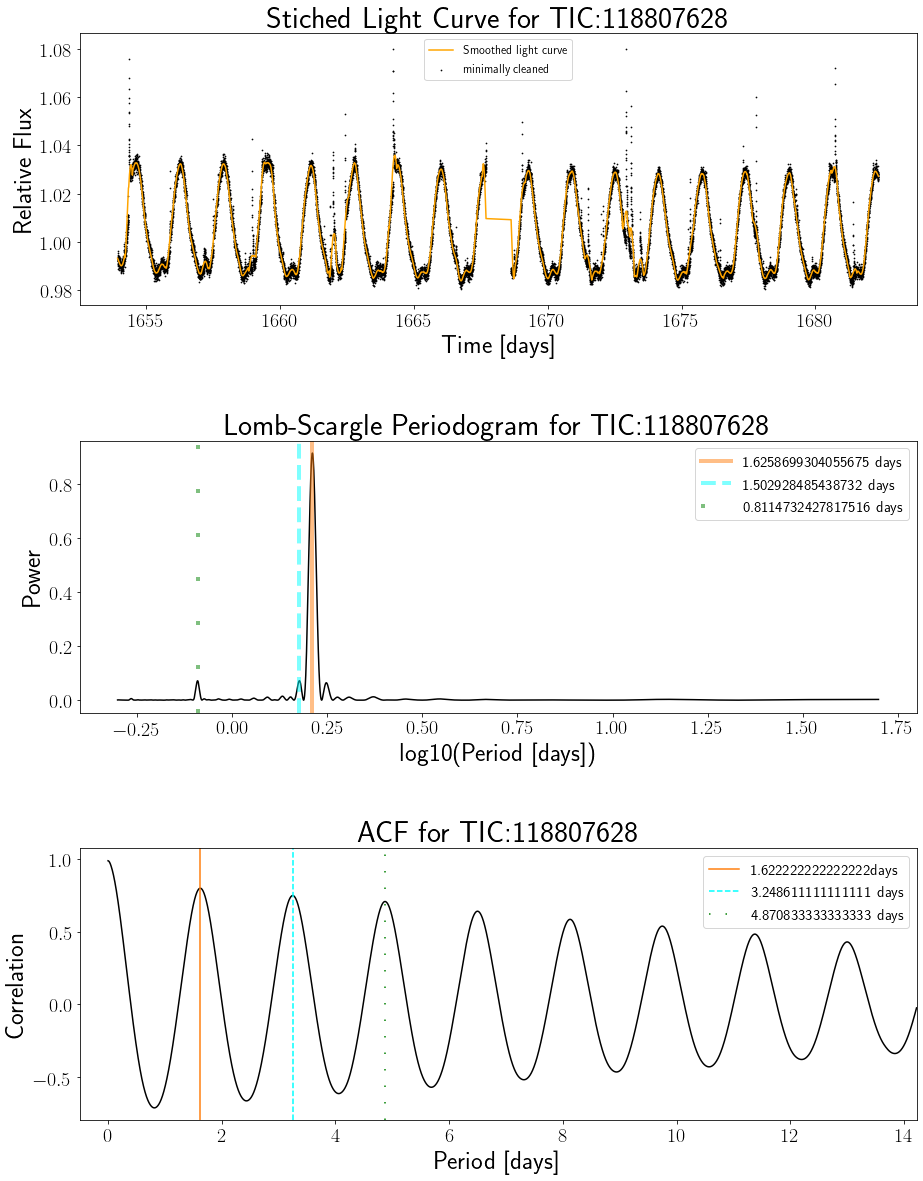

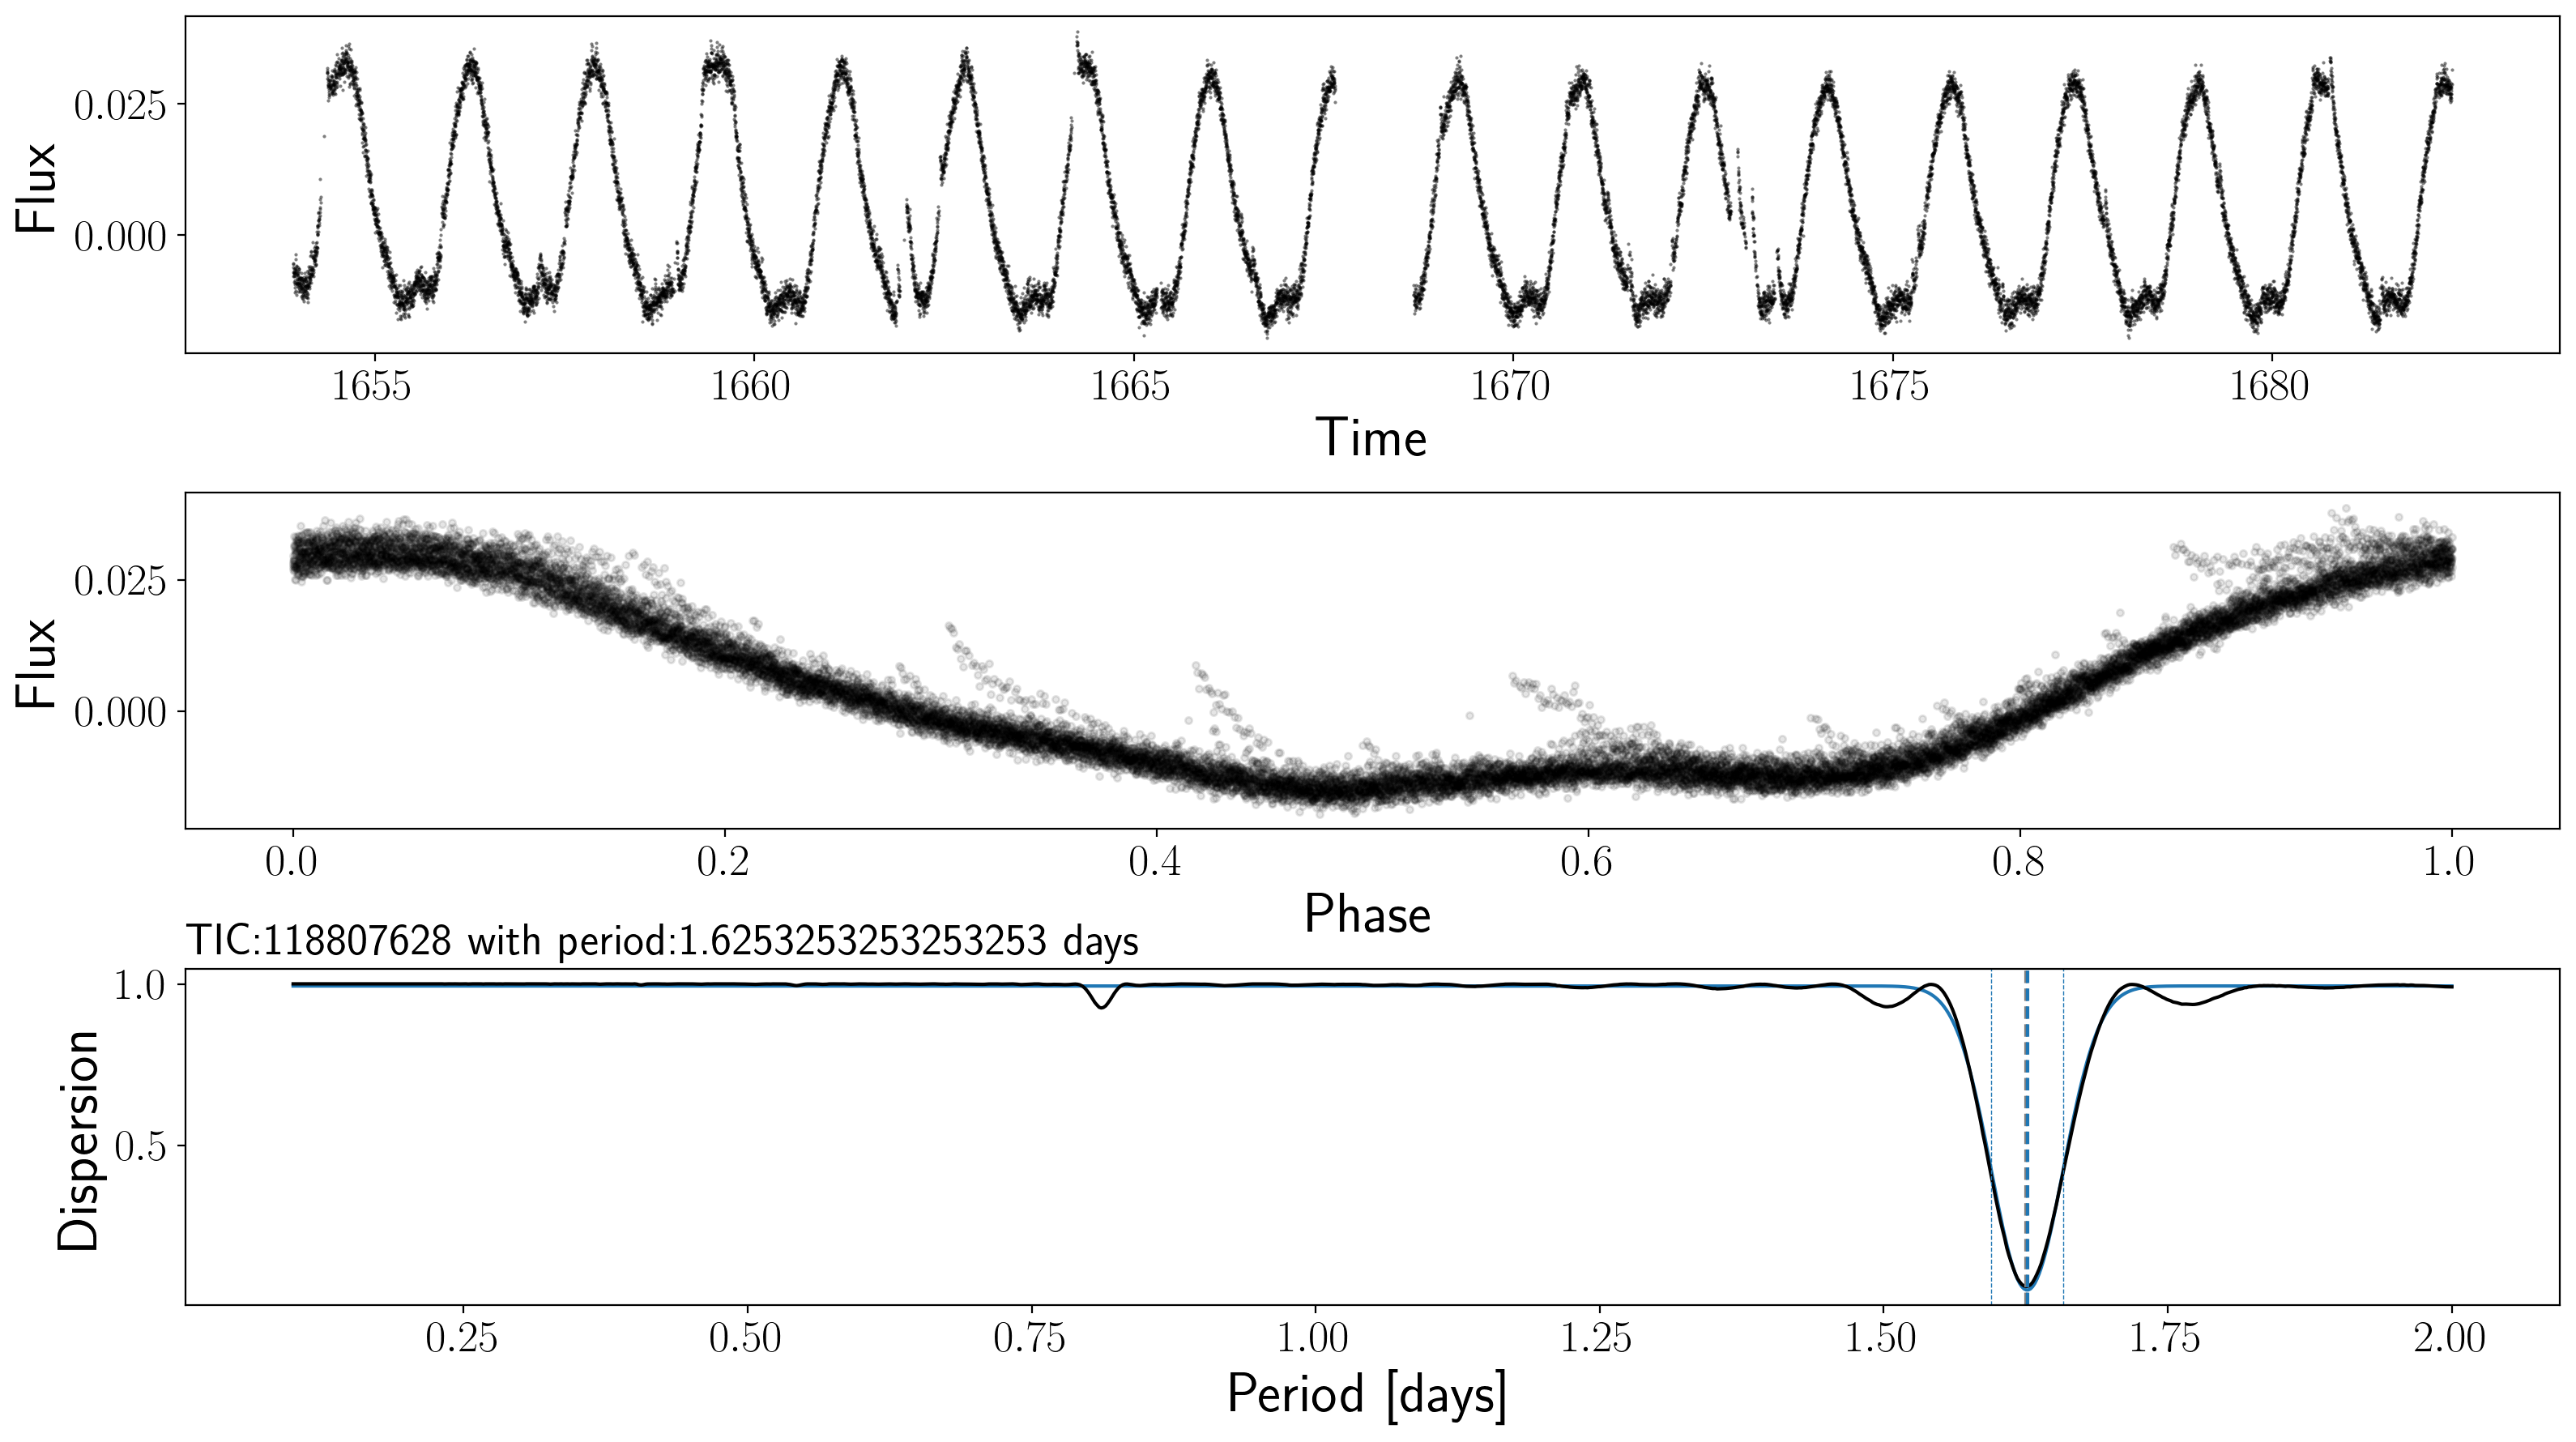

In [5]:
#to store calculated stats
tic_list = [] #to verify picking order stays same
pdms_err =[] 
pdms =[]

#opening cleaned lcfiles
for tic in tics_list:
    print(tic)
    lc = fits.open('data/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)) #lk cant find flux attribute
    data = lc[1].data #all the data
    flux1 = data['FLUX']
    flux_err1 = data['FLUX_ERR']
    time1 = data['TIME']
    cadence = data['CADENCENO']
    quality = data['QUALITY']
#extra cleaning- ruths tutorial
    # Calculate the median so that we can median-normalize.
    med = np.median(flux1)
    # Do an initial sigma clip to remove big outliers.
    m = sigma_clipping.sigma_clip(flux1/med - 1, nsigma=5)
    x, y, yerr = time1[m], flux1[m]/med - 1, flux_err1[m]/med

    # Then a sigma clip using a Sav-Gol filter for smoothing
    smooth, mask = sigma_clipping.filter_sigma_clip(x, y, window_length=199)
    time, flux, flux_err = x[mask], y[mask], yerr[mask]
#creating model & gathering stats
    rotate = ss.RotationModel(time, flux, flux_err)
#ls
    ls_period = rotate.ls_rotation()
    power = rotate.power
    freq = rotate.freq
    ps = 1./freq
    peaks = np.array([i for i in range(1, len(ps)-1) if power[i-1] < \
                power[i] and power[i+1] < power[i]])
    peak_amps_low2high = np.sort(power[peaks])
    second_rp = ps[power == peak_amps_low2high[-2]][0]
    third_rp = ps[power == peak_amps_low2high[-3]][0]
#acf
    tess_cadence = 1./24./30.
    acf_rp = rotate.acf_rotation(tess_cadence)
    x2 = rotate.lags
    y2 = rotate.acf
    peaks2 = np.array([i for i in range(1,len(y2)-1) if y2[i-1] < y2[i] and \
                     y2[i+1] <y2[i]])
    x_peaks = x2[peaks2]
    y_peaks = y2[peaks2]
    inds = np.argsort(y_peaks)
    xpeaks = x_peaks[inds][::-1]
    if len(xpeaks) >= 2:
        acfrp2 = xpeaks[1]
    else:
        acfrp2 = acf_rp
    if len(xpeaks) >= 3:
        acfrp3 = xpeaks[2]
    else:
        acfrp3 = acf_rp
#plots
    
    fig, axs = plt.subplots(3,1,figsize=(15,20))
    plt.subplots_adjust(hspace=0.5)
    axs[0].scatter(time1,flux1,color='k',s=.5,label='minimally cleaned')
    axs[0].plot(x, smooth+1,color='orange', label="Smoothed light curve")
    axs[0].set_xlabel('Time [days]')
    axs[0].set_ylabel('Relative Flux')
    axs[0].set_title('Stiched Light Curve for TIC:{}'.format(tic),fontsize=30);
    axs[0].legend(prop={'size': 12})
    
    axs[1].plot(-np.log10(freq), power, "k", zorder=0)
    axs[1].axvline(np.log10(ls_period), color="C1", lw=4, alpha=0.5,
                    zorder=1,label=('{} days'.format(ls_period)))
    axs[1].axvline(np.log10(second_rp),lw=4,alpha=0.5,zorder=2,linestyle='--',color='cyan',label=('{} days'.format(second_rp)))
    axs[1].axvline(np.log10(third_rp),lw=4,alpha=0.5,zorder=3,linestyle=(0, (1, 10)),color='g',label=('{} days'.format(third_rp)))
    axs[1].set_xlabel("log10(Period [days])")
    axs[1].set_ylabel("Power");
    axs[1].set_title('Lomb-Scargle Periodogram for TIC:{}'.format(tic),fontsize=30)
    axs[1].legend(prop={'size': 15})
    
    axs[2].plot(x2,y2,color='k')
    axs[2].axvline(acf_rp,color="C1",label='{}days'.format(acf_rp))
    axs[2].axvline(acfrp2,color='cyan',linestyle='--',label='{} days'.format(acfrp2))
    axs[2].axvline(acfrp3,color='green',linestyle=(0, (1, 10)),label="{} days".format(acfrp3))
    axs[2].set_xlabel("Period [days]")
    axs[2].set_ylabel("Correlation")
    axs[2].set_xlim(-0.5,max(x2))#acfrp3+5)
    axs[2].set_title('ACF for TIC:{}'.format(tic),fontsize=30)
    axs[2].legend(prop={'size': 15})
    
    filename = 'data/SECONDRUN/plots/{}/plots'.format(tic)
    ##os.makedirs(os.path.dirname(filename), exist_ok=True)
    ##plt.savefig(filename)
   # plt.close()
    
#pdm
    period_grid = np.linspace(.1,2,1000)
    pdm_rp, pdm_err = rotate.pdm_rotation(period_grid, pdm_nbins = 10)
    print('pdm:',pdm_rp)
    tic_list.append(tic)
    ##np.save('data/SECONDRUN/tic_order_pdm',tic_list)
    pdms.append(pdm_rp)
    ##np.save('data/SECONDRUN/pdm',pdms)
    pdms_err.append(pdm_err)
    ##np.save('data/SECONDRUN/pdm_err',pdms_err)
#pdm plots
    rotate.pdm_plot()
    plt.title('TIC:{} with period:{} days'.format(tic,pdm_rp),fontsize=20,loc='left')
    filename2 = 'data/SECONDRUN/plots/{}/pdm_plots'.format(tic)
    ##os.makedirs(os.path.dirname(filename2), exist_ok=True)
    ##plt.savefig(filename2)
  #  plt.close()
    print('ENDING  TIC:',tic)